<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment1/workbook-task1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import io
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Training data set

For this task, we use a specific data set prepared using images from the [Omniglot dataset](https://github.com/brendenlake/omniglot). The provided training data set contains 18.800 binary images of handwritten characters of size (28,28). Each of these images depicts one of 893 different characters from 29 different alphabets. Each image is accompanied by a label that is encoded as an interger $y\in\{0, 1, ..., 892\}$ that indicate the caracter depicted in the image. The following cell provides code that loads the data from hardcoded URLs.

In [2]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 
        
# Downloading may take a while..
train_x = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/tvQmLyY7MhVsADb/download').astype(float)
train_x = train_x.reshape(train_x.shape[0], 1, 28, 28)
train_y = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/z234AHrQqx9RVGH/download').astype(float)

print(f"train_x shape: {train_x.shape}")
print(f"train_y shape: {train_y.shape}\n")

train_x shape: (18800, 1, 28, 28)
train_y shape: (18800,)



### Query data set

The query dataset contains 100 sets of 6 images each. The images are also of hand written characters, however these characters are not present in the training data set. The characters in the query data set all come from the Greek alphabet that is not part of the set of alphabets in the training data. 

Each test set consists of 1 query image and 5 candidate images. All images are the same size (28x28). The test data is organized in two numpy arrays. One for the query images with shape (100, 1, 28, 28) and another for the candidate imagaes with shape (100, 5, 28, 28). 

The task is to develop a model that enables selecting the image which is depicting the same character as the anchor image out of 5 test images. These test images are declared in the `query_x` numpy array . 

Finally, we plot the first 5 cases in the query dataset. The first column corresponds with the anchor images of each of the 5 cases. All other images are test images from which the task is to recognize the anchor image. The image enclosed in a red box denotes the target image that your model should be able to recognize as the same class as the anchor image. 

In [3]:
query_dataset = load_numpy_arr_from_url("https://surfdrive.surf.nl/files/index.php/s/YGn5gb7unBEuCLB/download").astype(float)
queries_true = load_numpy_arr_from_url("https://surfdrive.surf.nl/files/index.php/s/0sPeeIFB3W9RPZG/download")

queries, candidates_sets = np.split(query_dataset, [1], axis=1)
queries = queries.astype(float)
candidates_sets = candidates_sets.astype(float)


print(f"query images have shape: {queries.shape}")
print(f"target sets have shape: {candidates_sets.shape}")
print(f"ground truth: {queries_true.shape}")

query images have shape: (100, 1, 28, 28)
target sets have shape: (100, 5, 28, 28)
ground truth: (100,)


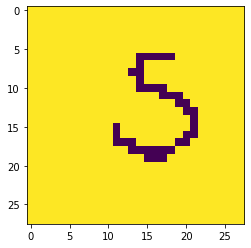

In [4]:
# plot anchor image
im = train_x[123].reshape(28,28,1)
plt.imshow(im)

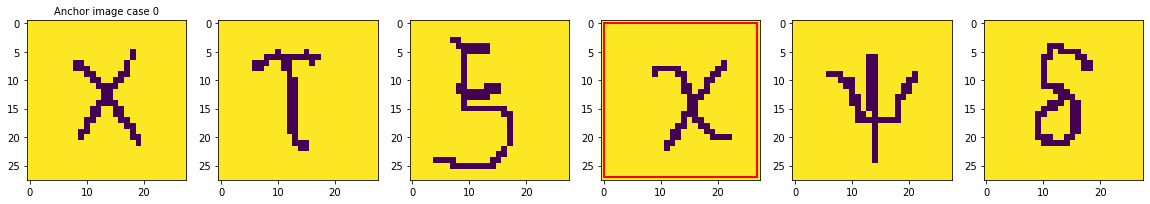

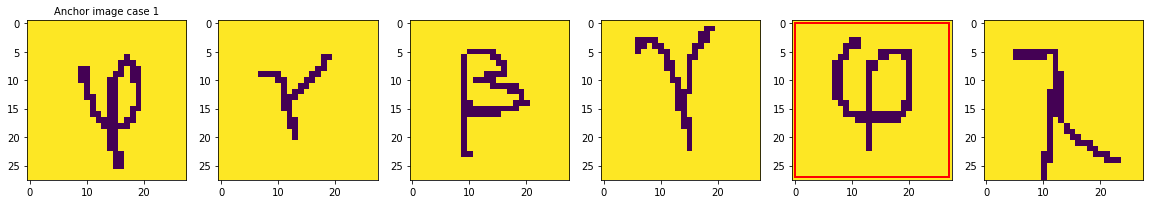

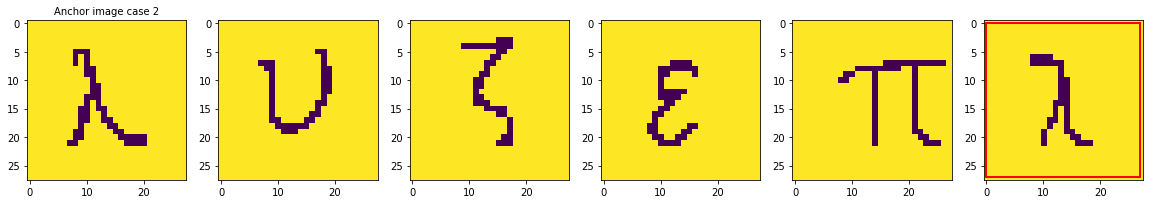

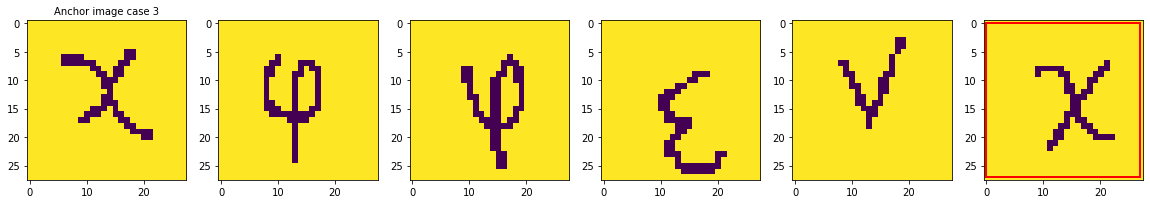

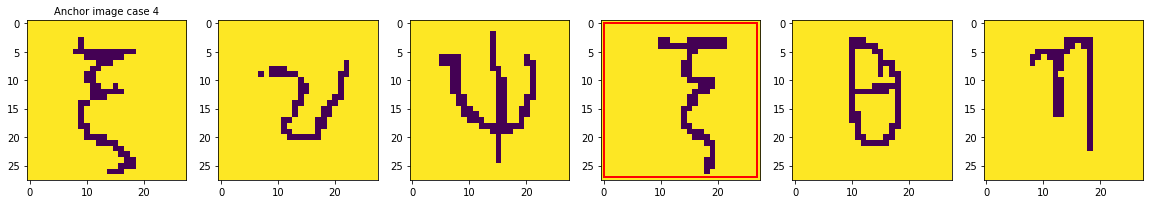

In [5]:
from matplotlib.patches import Rectangle

def plot_case(caseID):
    """
    Plots a single sample of the query dataset
    
    Inputs
    caseID: Integer between 0 and 99, each corresponding to a single sample in the query dataset 
    """
    
    f, axes = plt.subplots(1, 6, figsize=(20,5))
    
    # plot anchor image
    axes[0].imshow(queries[caseID, 0])
    axes[0].set_title(f"Anchor image case {caseID}", fontsize=10)
    
    # show all test images images 
    [ax.imshow(candidates_sets[caseID, i]) for i, ax in enumerate(axes[1:])]
    
    
    # Add the patch to the Axes
    axes[queries_true[caseID]].add_patch(Rectangle((0,0),27,27,linewidth=2, edgecolor='r',facecolor='none'))
    
    
    
    
# plot the first five samples of the query datset
[plot_case(caseID) for caseID in range(5)] ;

## Embedding net

EmbeddingNet is the branch of the triplet model that transforms data to an embeddings space.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()

        self.front_layer_1 = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
         )

        self.front_layer_2 = nn.Sequential(
            nn.Linear(2304, 1024),
            nn.ReLU(inplace=True),
#             nn.Linear(1024, 512),
#             nn.ReLU(inplace=True),
        )

        self.last_layer = nn.Linear(1024, 940)

    def forward(self, x):
        """Perform forward."""
        # conv layers
        x = self.front_layer_1(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.front_layer_2(x)
        #print(x.shape)
        x = self.last_layer(x)
        #print(x.shape)
        return x
    
    def get_embedding(self, x):
        return self.forward(x)

`BalancedBatchSampler` to create a minibatch that contains $N$ classes and $M$ samples for each class.

In [7]:
from torch.utils.data.sampler import BatchSampler
import numpy as np
class BalancedBatchSampler(BatchSampler):
    """
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(  np.array(self.labels) == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=True)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

### Splitting the data into training set and validation set

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, stratify=train_y, random_state=42)

In [9]:
train_batch_sampler = BalancedBatchSampler(y_train.tolist(), n_classes=15, n_samples=25)
val_batch_sampler = BalancedBatchSampler(y_val.tolist(), n_classes=15, n_samples=25)

train_dataset = [[X_train[i], y_train[i]] for i in range(len(X_train))]
val_dataset = [[X_val[i], y_val[i]] for i in range(len(X_val))]

# create the data loader
triplets_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler)
triplets_val_loader = torch.utils.data.DataLoader(val_dataset, batch_sampler=val_batch_sampler)

### Define Triplet Selector and Triplet loss

In [10]:
def pdist(vectors):
    """
    Calculate the distance matrix (Euclidean distance)
    
    Input:
    vectors: numpy.ndarray - the n-dimensional input vector
    
    Returns:
    distance_matrix: numpy.ndarray - the distance matrix
    """
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix

In [12]:
from itertools import combinations

class RandomTripletSelector():
    """
    Select random negative  example for  each positive pair to create triplets
    """

    def __init__(self):
        super(RandomTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs

            # random choose one negative example for each positive pair
            temp_triplets = [[anchor_positive[0], anchor_positive[1], np.random.choice(negative_indices)] for anchor_positive in anchor_positives]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))

In [13]:
class TripletLoss(nn.Module):
    """
    Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()

            
        anchor_idx= triplets[:, 0]  
        positive_idx= triplets[:, 1]  
        negative_idx= triplets[:, 2]  
            
            
        ap_distances = (embeddings[anchor_idx] - embeddings[positive_idx]).pow(2).sum(1)  # .pow(.5)
        an_distances = (embeddings[anchor_idx] - embeddings[negative_idx]).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(ap_distances - an_distances + self.margin)

        return losses.mean()

### Model Training

In [14]:
import numpy as np
from tqdm import tqdm


class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 train_criterion: torch.nn.Module,
                 val_criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        
        self.model = model
        self.train_criterion = train_criterion
        self.val_criterion = val_criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs

    def run_trainer(self):
        all_train_losses = []
        all_valid_losses = []
        for epoch in tqdm(range(self.epochs)):
            self.model.train()  # train mode

            train_losses=[]
            for batch in self.training_DataLoader:

                x,y=batch
                input, target = x.to(self.device, dtype=torch.float), y.to(self.device, dtype=torch.float)  # send to device (GPU or CPU)
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input)  # one forward pass
                loss = self.train_criterion(out, target)  # calculate loss
                 
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters

            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here
            
            for batch in self.validation_DataLoader:

                x,y=batch
                input, target = x.to(self.device, dtype=torch.float), y.to(self.device, dtype=torch.float)  # send to device (GPU or CPU)

                with torch.no_grad():
                    out = self.model(input)   # one forward pass
                    loss = self.val_criterion(out, target) # calculate loss
                 
                    loss_value = loss.item()
                    valid_losses.append(loss_value)
                    
            # keep track of training and validation loss each epoch
            all_train_losses.append(np.mean(train_losses))
            all_valid_losses.append(np.mean(np.mean(valid_losses)))

            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')
        return all_train_losses, all_valid_losses

In [15]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using cuda (trust issue)')
else:
    device=torch.device('cpu')
    
# model
mined_embedding_net = EmbeddingNet()
mined_model = mined_embedding_net.to(device)

num_epochs = 200
# margin value
margin=1

# criterion
#train_criterion = TripletLoss(margin,  Informative_Negative_TripletSelector(margin))
train_criterion = TripletLoss(margin,  RandomTripletSelector())
val_criterion = TripletLoss(margin, RandomTripletSelector())

# optimizer
optimizer = torch.optim.SGD(mined_model.parameters(), lr=0.001, momentum=0.9)

# trainer
trainer = Trainer(model=mined_model,
                  device=device,
                  train_criterion=train_criterion,
                  val_criterion = val_criterion,
                  optimizer=optimizer,
                  training_DataLoader=triplets_train_loader,
                  validation_DataLoader=triplets_val_loader,
                  epochs=num_epochs)

# start training
train_losses, val_losses = trainer.run_trainer()

Using cuda (trust issue)


  0%|▍                                                                                 | 1/200 [00:07<24:29,  7.38s/it]

EPOCH: 001/200 LOSS: 0.2732 VAL-LOSS: 0.4540


  1%|▊                                                                                 | 2/200 [00:13<23:11,  7.03s/it]

EPOCH: 002/200 LOSS: 0.1407 VAL-LOSS: 0.1076


  2%|█▏                                                                                | 3/200 [00:19<22:09,  6.75s/it]

EPOCH: 003/200 LOSS: 0.0959 VAL-LOSS: 0.0734


  2%|█▋                                                                                | 4/200 [00:25<21:29,  6.58s/it]

EPOCH: 004/200 LOSS: 0.0688 VAL-LOSS: 0.0532


  2%|██                                                                                | 5/200 [00:32<21:07,  6.50s/it]

EPOCH: 005/200 LOSS: 0.0611 VAL-LOSS: 0.0460


  3%|██▍                                                                               | 6/200 [00:42<24:43,  7.65s/it]

EPOCH: 006/200 LOSS: 0.0470 VAL-LOSS: 0.0422


  4%|██▊                                                                               | 7/200 [00:53<27:44,  8.62s/it]

EPOCH: 007/200 LOSS: 0.0410 VAL-LOSS: 0.0541


  4%|███▎                                                                              | 8/200 [01:04<29:56,  9.36s/it]

EPOCH: 008/200 LOSS: 0.0433 VAL-LOSS: 0.0633


  4%|███▋                                                                              | 9/200 [01:15<31:21,  9.85s/it]

EPOCH: 009/200 LOSS: 0.0333 VAL-LOSS: 0.0442


  5%|████                                                                             | 10/200 [01:26<32:11, 10.17s/it]

EPOCH: 010/200 LOSS: 0.0309 VAL-LOSS: 0.0492


  6%|████▍                                                                            | 11/200 [01:37<32:43, 10.39s/it]

EPOCH: 011/200 LOSS: 0.0327 VAL-LOSS: 0.0405


  6%|████▊                                                                            | 12/200 [01:48<33:05, 10.56s/it]

EPOCH: 012/200 LOSS: 0.0287 VAL-LOSS: 0.0374


  6%|█████▎                                                                           | 13/200 [01:59<33:23, 10.71s/it]

EPOCH: 013/200 LOSS: 0.0299 VAL-LOSS: 0.0454


  7%|█████▋                                                                           | 14/200 [02:10<33:22, 10.77s/it]

EPOCH: 014/200 LOSS: 0.0264 VAL-LOSS: 0.0225


  8%|██████                                                                           | 15/200 [02:21<33:28, 10.86s/it]

EPOCH: 015/200 LOSS: 0.0230 VAL-LOSS: 0.0333


  8%|██████▍                                                                          | 16/200 [02:32<33:25, 10.90s/it]

EPOCH: 016/200 LOSS: 0.0265 VAL-LOSS: 0.0215


  8%|██████▉                                                                          | 17/200 [02:43<33:16, 10.91s/it]

EPOCH: 017/200 LOSS: 0.0281 VAL-LOSS: 0.0347


  9%|███████▎                                                                         | 18/200 [02:54<33:05, 10.91s/it]

EPOCH: 018/200 LOSS: 0.0218 VAL-LOSS: 0.0263


 10%|███████▋                                                                         | 19/200 [03:05<32:59, 10.94s/it]

EPOCH: 019/200 LOSS: 0.0222 VAL-LOSS: 0.0218


 10%|████████                                                                         | 20/200 [03:16<32:47, 10.93s/it]

EPOCH: 020/200 LOSS: 0.0225 VAL-LOSS: 0.0327


 10%|████████▌                                                                        | 21/200 [03:27<32:43, 10.97s/it]

EPOCH: 021/200 LOSS: 0.0216 VAL-LOSS: 0.0307


 11%|████████▉                                                                        | 22/200 [03:38<32:35, 10.98s/it]

EPOCH: 022/200 LOSS: 0.0202 VAL-LOSS: 0.0442


 12%|█████████▎                                                                       | 23/200 [03:49<32:23, 10.98s/it]

EPOCH: 023/200 LOSS: 0.0212 VAL-LOSS: 0.0252


 12%|█████████▋                                                                       | 24/200 [04:00<32:09, 10.96s/it]

EPOCH: 024/200 LOSS: 0.0189 VAL-LOSS: 0.0478


 12%|██████████▏                                                                      | 25/200 [04:11<32:03, 10.99s/it]

EPOCH: 025/200 LOSS: 0.0187 VAL-LOSS: 0.0346


 13%|██████████▌                                                                      | 26/200 [04:22<31:57, 11.02s/it]

EPOCH: 026/200 LOSS: 0.0193 VAL-LOSS: 0.0329


 14%|██████████▉                                                                      | 27/200 [04:33<31:46, 11.02s/it]

EPOCH: 027/200 LOSS: 0.0171 VAL-LOSS: 0.0208


 14%|███████████▎                                                                     | 28/200 [04:44<31:35, 11.02s/it]

EPOCH: 028/200 LOSS: 0.0191 VAL-LOSS: 0.0339


 14%|███████████▋                                                                     | 29/200 [04:55<31:19, 10.99s/it]

EPOCH: 029/200 LOSS: 0.0166 VAL-LOSS: 0.0195


 15%|████████████▏                                                                    | 30/200 [05:06<31:10, 11.00s/it]

EPOCH: 030/200 LOSS: 0.0147 VAL-LOSS: 0.0294


 16%|████████████▌                                                                    | 31/200 [05:17<30:52, 10.96s/it]

EPOCH: 031/200 LOSS: 0.0154 VAL-LOSS: 0.0330


 16%|████████████▉                                                                    | 32/200 [05:28<30:45, 10.98s/it]

EPOCH: 032/200 LOSS: 0.0168 VAL-LOSS: 0.0310


 16%|█████████████▎                                                                   | 33/200 [05:39<30:37, 11.00s/it]

EPOCH: 033/200 LOSS: 0.0181 VAL-LOSS: 0.0325


 17%|█████████████▊                                                                   | 34/200 [05:50<30:23, 10.99s/it]

EPOCH: 034/200 LOSS: 0.0152 VAL-LOSS: 0.0392


 18%|██████████████▏                                                                  | 35/200 [06:01<30:17, 11.01s/it]

EPOCH: 035/200 LOSS: 0.0132 VAL-LOSS: 0.0331


 18%|██████████████▌                                                                  | 36/200 [06:12<30:08, 11.03s/it]

EPOCH: 036/200 LOSS: 0.0148 VAL-LOSS: 0.0410


 18%|██████████████▉                                                                  | 37/200 [06:23<29:59, 11.04s/it]

EPOCH: 037/200 LOSS: 0.0154 VAL-LOSS: 0.0325


 19%|███████████████▍                                                                 | 38/200 [06:34<29:47, 11.04s/it]

EPOCH: 038/200 LOSS: 0.0134 VAL-LOSS: 0.0140


 20%|███████████████▊                                                                 | 39/200 [06:45<29:37, 11.04s/it]

EPOCH: 039/200 LOSS: 0.0131 VAL-LOSS: 0.0188


 20%|████████████████▏                                                                | 40/200 [06:56<29:26, 11.04s/it]

EPOCH: 040/200 LOSS: 0.0138 VAL-LOSS: 0.0377


 20%|████████████████▌                                                                | 41/200 [07:07<29:12, 11.02s/it]

EPOCH: 041/200 LOSS: 0.0129 VAL-LOSS: 0.0202


 21%|█████████████████                                                                | 42/200 [07:18<29:01, 11.03s/it]

EPOCH: 042/200 LOSS: 0.0127 VAL-LOSS: 0.0140


 22%|█████████████████▍                                                               | 43/200 [07:29<28:51, 11.03s/it]

EPOCH: 043/200 LOSS: 0.0125 VAL-LOSS: 0.0104


 22%|█████████████████▊                                                               | 44/200 [07:40<28:41, 11.03s/it]

EPOCH: 044/200 LOSS: 0.0140 VAL-LOSS: 0.0350


 22%|██████████████████▏                                                              | 45/200 [07:51<28:32, 11.05s/it]

EPOCH: 045/200 LOSS: 0.0103 VAL-LOSS: 0.0176


 23%|██████████████████▋                                                              | 46/200 [08:02<28:21, 11.05s/it]

EPOCH: 046/200 LOSS: 0.0108 VAL-LOSS: 0.0200


 24%|███████████████████                                                              | 47/200 [08:13<28:12, 11.06s/it]

EPOCH: 047/200 LOSS: 0.0122 VAL-LOSS: 0.0239


 24%|███████████████████▍                                                             | 48/200 [08:24<28:02, 11.07s/it]

EPOCH: 048/200 LOSS: 0.0111 VAL-LOSS: 0.0164


 24%|███████████████████▊                                                             | 49/200 [08:35<27:41, 11.00s/it]

EPOCH: 049/200 LOSS: 0.0126 VAL-LOSS: 0.0182


 25%|████████████████████▎                                                            | 50/200 [08:46<27:25, 10.97s/it]

EPOCH: 050/200 LOSS: 0.0103 VAL-LOSS: 0.0188


 26%|████████████████████▋                                                            | 51/200 [08:57<27:17, 10.99s/it]

EPOCH: 051/200 LOSS: 0.0119 VAL-LOSS: 0.0282


 26%|█████████████████████                                                            | 52/200 [09:08<27:07, 11.00s/it]

EPOCH: 052/200 LOSS: 0.0118 VAL-LOSS: 0.0166


 26%|█████████████████████▍                                                           | 53/200 [09:19<26:56, 11.00s/it]

EPOCH: 053/200 LOSS: 0.0110 VAL-LOSS: 0.0119


 27%|█████████████████████▊                                                           | 54/200 [09:30<26:46, 11.01s/it]

EPOCH: 054/200 LOSS: 0.0096 VAL-LOSS: 0.0094


 28%|██████████████████████▎                                                          | 55/200 [09:41<26:38, 11.02s/it]

EPOCH: 055/200 LOSS: 0.0116 VAL-LOSS: 0.0115


 28%|██████████████████████▋                                                          | 56/200 [09:52<26:29, 11.04s/it]

EPOCH: 056/200 LOSS: 0.0110 VAL-LOSS: 0.0208


 28%|███████████████████████                                                          | 57/200 [10:03<26:18, 11.04s/it]

EPOCH: 057/200 LOSS: 0.0114 VAL-LOSS: 0.0154


 29%|███████████████████████▍                                                         | 58/200 [10:14<26:08, 11.05s/it]

EPOCH: 058/200 LOSS: 0.0102 VAL-LOSS: 0.0204


 30%|███████████████████████▉                                                         | 59/200 [10:25<25:57, 11.04s/it]

EPOCH: 059/200 LOSS: 0.0105 VAL-LOSS: 0.0227


 30%|████████████████████████▎                                                        | 60/200 [10:36<25:45, 11.04s/it]

EPOCH: 060/200 LOSS: 0.0098 VAL-LOSS: 0.0261


 30%|████████████████████████▋                                                        | 61/200 [10:47<25:34, 11.04s/it]

EPOCH: 061/200 LOSS: 0.0108 VAL-LOSS: 0.0257


 31%|█████████████████████████                                                        | 62/200 [10:58<25:21, 11.02s/it]

EPOCH: 062/200 LOSS: 0.0095 VAL-LOSS: 0.0114


 32%|█████████████████████████▌                                                       | 63/200 [11:09<25:09, 11.02s/it]

EPOCH: 063/200 LOSS: 0.0096 VAL-LOSS: 0.0250


 32%|█████████████████████████▉                                                       | 64/200 [11:20<24:58, 11.02s/it]

EPOCH: 064/200 LOSS: 0.0101 VAL-LOSS: 0.0112


 32%|██████████████████████████▎                                                      | 65/200 [11:31<24:47, 11.02s/it]

EPOCH: 065/200 LOSS: 0.0099 VAL-LOSS: 0.0181


 33%|██████████████████████████▋                                                      | 66/200 [11:43<24:38, 11.04s/it]

EPOCH: 066/200 LOSS: 0.0115 VAL-LOSS: 0.0193


 34%|███████████████████████████▏                                                     | 67/200 [11:54<24:27, 11.03s/it]

EPOCH: 067/200 LOSS: 0.0082 VAL-LOSS: 0.0214


 34%|███████████████████████████▌                                                     | 68/200 [12:05<24:12, 11.01s/it]

EPOCH: 068/200 LOSS: 0.0073 VAL-LOSS: 0.0407


 34%|███████████████████████████▉                                                     | 69/200 [12:16<24:02, 11.01s/it]

EPOCH: 069/200 LOSS: 0.0091 VAL-LOSS: 0.0047


 35%|████████████████████████████▎                                                    | 70/200 [12:27<23:53, 11.02s/it]

EPOCH: 070/200 LOSS: 0.0090 VAL-LOSS: 0.0225


 36%|████████████████████████████▊                                                    | 71/200 [12:38<23:43, 11.03s/it]

EPOCH: 071/200 LOSS: 0.0077 VAL-LOSS: 0.0139


 36%|█████████████████████████████▏                                                   | 72/200 [12:49<23:26, 10.99s/it]

EPOCH: 072/200 LOSS: 0.0075 VAL-LOSS: 0.0137


 36%|█████████████████████████████▌                                                   | 73/200 [12:59<23:14, 10.98s/it]

EPOCH: 073/200 LOSS: 0.0091 VAL-LOSS: 0.0104


 37%|█████████████████████████████▉                                                   | 74/200 [13:10<22:56, 10.93s/it]

EPOCH: 074/200 LOSS: 0.0110 VAL-LOSS: 0.0125


 38%|██████████████████████████████▍                                                  | 75/200 [13:21<22:48, 10.95s/it]

EPOCH: 075/200 LOSS: 0.0085 VAL-LOSS: 0.0232


 38%|██████████████████████████████▊                                                  | 76/200 [13:32<22:39, 10.97s/it]

EPOCH: 076/200 LOSS: 0.0077 VAL-LOSS: 0.0225


 38%|███████████████████████████████▏                                                 | 77/200 [13:43<22:31, 10.99s/it]

EPOCH: 077/200 LOSS: 0.0112 VAL-LOSS: 0.0119


 39%|███████████████████████████████▌                                                 | 78/200 [13:54<22:22, 11.00s/it]

EPOCH: 078/200 LOSS: 0.0070 VAL-LOSS: 0.0306


 40%|███████████████████████████████▉                                                 | 79/200 [14:05<22:09, 10.98s/it]

EPOCH: 079/200 LOSS: 0.0075 VAL-LOSS: 0.0158


 40%|████████████████████████████████▍                                                | 80/200 [14:16<21:57, 10.98s/it]

EPOCH: 080/200 LOSS: 0.0117 VAL-LOSS: 0.0210


 40%|████████████████████████████████▊                                                | 81/200 [14:27<21:47, 10.99s/it]

EPOCH: 081/200 LOSS: 0.0081 VAL-LOSS: 0.0050


 41%|█████████████████████████████████▏                                               | 82/200 [14:38<21:38, 11.01s/it]

EPOCH: 082/200 LOSS: 0.0092 VAL-LOSS: 0.0152


 42%|█████████████████████████████████▌                                               | 83/200 [14:49<21:27, 11.00s/it]

EPOCH: 083/200 LOSS: 0.0080 VAL-LOSS: 0.0170


 42%|██████████████████████████████████                                               | 84/200 [15:00<21:17, 11.01s/it]

EPOCH: 084/200 LOSS: 0.0082 VAL-LOSS: 0.0104


 42%|██████████████████████████████████▍                                              | 85/200 [15:11<21:06, 11.01s/it]

EPOCH: 085/200 LOSS: 0.0087 VAL-LOSS: 0.0152


 43%|██████████████████████████████████▊                                              | 86/200 [15:22<20:55, 11.02s/it]

EPOCH: 086/200 LOSS: 0.0089 VAL-LOSS: 0.0099


 44%|███████████████████████████████████▏                                             | 87/200 [15:33<20:46, 11.03s/it]

EPOCH: 087/200 LOSS: 0.0077 VAL-LOSS: 0.0314


 44%|███████████████████████████████████▋                                             | 88/200 [15:45<20:35, 11.03s/it]

EPOCH: 088/200 LOSS: 0.0079 VAL-LOSS: 0.0175


 44%|████████████████████████████████████                                             | 89/200 [15:56<20:25, 11.04s/it]

EPOCH: 089/200 LOSS: 0.0074 VAL-LOSS: 0.0117


 45%|████████████████████████████████████▍                                            | 90/200 [16:07<20:14, 11.04s/it]

EPOCH: 090/200 LOSS: 0.0078 VAL-LOSS: 0.0126


 46%|████████████████████████████████████▊                                            | 91/200 [16:18<20:03, 11.05s/it]

EPOCH: 091/200 LOSS: 0.0086 VAL-LOSS: 0.0151


 46%|█████████████████████████████████████▎                                           | 92/200 [16:29<19:49, 11.01s/it]

EPOCH: 092/200 LOSS: 0.0078 VAL-LOSS: 0.0144


 46%|█████████████████████████████████████▋                                           | 93/200 [16:40<19:35, 10.99s/it]

EPOCH: 093/200 LOSS: 0.0059 VAL-LOSS: 0.0181


 47%|██████████████████████████████████████                                           | 94/200 [16:50<19:20, 10.95s/it]

EPOCH: 094/200 LOSS: 0.0074 VAL-LOSS: 0.0168


 48%|██████████████████████████████████████▍                                          | 95/200 [17:01<19:06, 10.92s/it]

EPOCH: 095/200 LOSS: 0.0065 VAL-LOSS: 0.0236


 48%|██████████████████████████████████████▉                                          | 96/200 [17:12<18:55, 10.92s/it]

EPOCH: 096/200 LOSS: 0.0076 VAL-LOSS: 0.0143


 48%|███████████████████████████████████████▎                                         | 97/200 [17:23<18:42, 10.90s/it]

EPOCH: 097/200 LOSS: 0.0074 VAL-LOSS: 0.0123


 49%|███████████████████████████████████████▋                                         | 98/200 [17:34<18:38, 10.97s/it]

EPOCH: 098/200 LOSS: 0.0077 VAL-LOSS: 0.0231


 50%|████████████████████████████████████████                                         | 99/200 [17:45<18:24, 10.93s/it]

EPOCH: 099/200 LOSS: 0.0068 VAL-LOSS: 0.0158


 50%|████████████████████████████████████████                                        | 100/200 [17:56<18:16, 10.96s/it]

EPOCH: 100/200 LOSS: 0.0075 VAL-LOSS: 0.0069


 50%|████████████████████████████████████████▍                                       | 101/200 [18:07<18:04, 10.96s/it]

EPOCH: 101/200 LOSS: 0.0066 VAL-LOSS: 0.0279


 51%|████████████████████████████████████████▊                                       | 102/200 [18:18<17:52, 10.95s/it]

EPOCH: 102/200 LOSS: 0.0068 VAL-LOSS: 0.0206


 52%|█████████████████████████████████████████▏                                      | 103/200 [18:29<17:44, 10.98s/it]

EPOCH: 103/200 LOSS: 0.0054 VAL-LOSS: 0.0225


 52%|█████████████████████████████████████████▌                                      | 104/200 [18:40<17:34, 10.99s/it]

EPOCH: 104/200 LOSS: 0.0085 VAL-LOSS: 0.0131


 52%|██████████████████████████████████████████                                      | 105/200 [18:51<17:25, 11.01s/it]

EPOCH: 105/200 LOSS: 0.0069 VAL-LOSS: 0.0184


 53%|██████████████████████████████████████████▍                                     | 106/200 [19:02<17:14, 11.01s/it]

EPOCH: 106/200 LOSS: 0.0068 VAL-LOSS: 0.0108


 54%|██████████████████████████████████████████▊                                     | 107/200 [19:13<17:01, 10.98s/it]

EPOCH: 107/200 LOSS: 0.0073 VAL-LOSS: 0.0285


 54%|███████████████████████████████████████████▏                                    | 108/200 [19:24<16:48, 10.96s/it]

EPOCH: 108/200 LOSS: 0.0061 VAL-LOSS: 0.0177


 55%|███████████████████████████████████████████▌                                    | 109/200 [19:35<16:41, 11.01s/it]

EPOCH: 109/200 LOSS: 0.0063 VAL-LOSS: 0.0113


 55%|████████████████████████████████████████████                                    | 110/200 [19:46<16:28, 10.99s/it]

EPOCH: 110/200 LOSS: 0.0073 VAL-LOSS: 0.0148


 56%|████████████████████████████████████████████▍                                   | 111/200 [19:57<16:18, 10.99s/it]

EPOCH: 111/200 LOSS: 0.0075 VAL-LOSS: 0.0159


 56%|████████████████████████████████████████████▊                                   | 112/200 [20:08<16:09, 11.02s/it]

EPOCH: 112/200 LOSS: 0.0084 VAL-LOSS: 0.0211


 56%|█████████████████████████████████████████████▏                                  | 113/200 [20:19<16:00, 11.04s/it]

EPOCH: 113/200 LOSS: 0.0057 VAL-LOSS: 0.0206


 57%|█████████████████████████████████████████████▌                                  | 114/200 [20:30<15:51, 11.06s/it]

EPOCH: 114/200 LOSS: 0.0079 VAL-LOSS: 0.0117


 57%|██████████████████████████████████████████████                                  | 115/200 [20:41<15:37, 11.03s/it]

EPOCH: 115/200 LOSS: 0.0065 VAL-LOSS: 0.0168


 58%|██████████████████████████████████████████████▍                                 | 116/200 [20:52<15:24, 11.01s/it]

EPOCH: 116/200 LOSS: 0.0051 VAL-LOSS: 0.0068


 58%|██████████████████████████████████████████████▊                                 | 117/200 [21:03<15:12, 11.00s/it]

EPOCH: 117/200 LOSS: 0.0050 VAL-LOSS: 0.0039


 59%|███████████████████████████████████████████████▏                                | 118/200 [21:14<15:03, 11.02s/it]

EPOCH: 118/200 LOSS: 0.0070 VAL-LOSS: 0.0106


 60%|███████████████████████████████████████████████▌                                | 119/200 [21:25<14:54, 11.04s/it]

EPOCH: 119/200 LOSS: 0.0050 VAL-LOSS: 0.0138


 60%|████████████████████████████████████████████████                                | 120/200 [21:36<14:43, 11.05s/it]

EPOCH: 120/200 LOSS: 0.0057 VAL-LOSS: 0.0229


 60%|████████████████████████████████████████████████▍                               | 121/200 [21:47<14:30, 11.02s/it]

EPOCH: 121/200 LOSS: 0.0045 VAL-LOSS: 0.0200


 61%|████████████████████████████████████████████████▊                               | 122/200 [21:58<14:20, 11.03s/it]

EPOCH: 122/200 LOSS: 0.0063 VAL-LOSS: 0.0119


 62%|█████████████████████████████████████████████████▏                              | 123/200 [22:09<14:09, 11.04s/it]

EPOCH: 123/200 LOSS: 0.0063 VAL-LOSS: 0.0057


 62%|█████████████████████████████████████████████████▌                              | 124/200 [22:20<13:58, 11.04s/it]

EPOCH: 124/200 LOSS: 0.0067 VAL-LOSS: 0.0121


 62%|██████████████████████████████████████████████████                              | 125/200 [22:31<13:47, 11.04s/it]

EPOCH: 125/200 LOSS: 0.0065 VAL-LOSS: 0.0104


 63%|██████████████████████████████████████████████████▍                             | 126/200 [22:42<13:36, 11.03s/it]

EPOCH: 126/200 LOSS: 0.0067 VAL-LOSS: 0.0074


 64%|██████████████████████████████████████████████████▊                             | 127/200 [22:53<13:24, 11.02s/it]

EPOCH: 127/200 LOSS: 0.0064 VAL-LOSS: 0.0115


 64%|███████████████████████████████████████████████████▏                            | 128/200 [23:05<13:14, 11.03s/it]

EPOCH: 128/200 LOSS: 0.0061 VAL-LOSS: 0.0149


 64%|███████████████████████████████████████████████████▌                            | 129/200 [23:16<13:02, 11.02s/it]

EPOCH: 129/200 LOSS: 0.0064 VAL-LOSS: 0.0282


 65%|████████████████████████████████████████████████████                            | 130/200 [23:27<12:51, 11.02s/it]

EPOCH: 130/200 LOSS: 0.0044 VAL-LOSS: 0.0305


 66%|████████████████████████████████████████████████████▍                           | 131/200 [23:38<12:41, 11.04s/it]

EPOCH: 131/200 LOSS: 0.0051 VAL-LOSS: 0.0125


 66%|████████████████████████████████████████████████████▊                           | 132/200 [23:49<12:30, 11.03s/it]

EPOCH: 132/200 LOSS: 0.0045 VAL-LOSS: 0.0108


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [24:00<12:19, 11.03s/it]

EPOCH: 133/200 LOSS: 0.0059 VAL-LOSS: 0.0165


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [24:11<12:09, 11.05s/it]

EPOCH: 134/200 LOSS: 0.0053 VAL-LOSS: 0.0145


 68%|██████████████████████████████████████████████████████                          | 135/200 [24:22<11:58, 11.05s/it]

EPOCH: 135/200 LOSS: 0.0049 VAL-LOSS: 0.0183


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [24:33<11:46, 11.04s/it]

EPOCH: 136/200 LOSS: 0.0059 VAL-LOSS: 0.0028


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [24:44<11:35, 11.04s/it]

EPOCH: 137/200 LOSS: 0.0051 VAL-LOSS: 0.0159


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [24:55<11:23, 11.03s/it]

EPOCH: 138/200 LOSS: 0.0055 VAL-LOSS: 0.0209


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [25:06<11:10, 10.99s/it]

EPOCH: 139/200 LOSS: 0.0046 VAL-LOSS: 0.0094


 70%|████████████████████████████████████████████████████████                        | 140/200 [25:17<10:59, 10.99s/it]

EPOCH: 140/200 LOSS: 0.0056 VAL-LOSS: 0.0114


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [25:28<10:48, 11.00s/it]

EPOCH: 141/200 LOSS: 0.0049 VAL-LOSS: 0.0139


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [25:39<10:38, 11.02s/it]

EPOCH: 142/200 LOSS: 0.0050 VAL-LOSS: 0.0212


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [25:50<10:28, 11.03s/it]

EPOCH: 143/200 LOSS: 0.0062 VAL-LOSS: 0.0106


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [26:01<10:18, 11.04s/it]

EPOCH: 144/200 LOSS: 0.0038 VAL-LOSS: 0.0210


 72%|██████████████████████████████████████████████████████████                      | 145/200 [26:12<10:07, 11.05s/it]

EPOCH: 145/200 LOSS: 0.0055 VAL-LOSS: 0.0096


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [26:23<09:56, 11.04s/it]

EPOCH: 146/200 LOSS: 0.0060 VAL-LOSS: 0.0175


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [26:34<09:44, 11.03s/it]

EPOCH: 147/200 LOSS: 0.0048 VAL-LOSS: 0.0100


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [26:45<09:33, 11.02s/it]

EPOCH: 148/200 LOSS: 0.0035 VAL-LOSS: 0.0145


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [26:56<09:21, 11.02s/it]

EPOCH: 149/200 LOSS: 0.0042 VAL-LOSS: 0.0198


 75%|████████████████████████████████████████████████████████████                    | 150/200 [27:07<09:10, 11.01s/it]

EPOCH: 150/200 LOSS: 0.0043 VAL-LOSS: 0.0088


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [27:18<08:59, 11.02s/it]

EPOCH: 151/200 LOSS: 0.0047 VAL-LOSS: 0.0070


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [27:29<08:48, 11.01s/it]

EPOCH: 152/200 LOSS: 0.0063 VAL-LOSS: 0.0202


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [27:40<08:37, 11.02s/it]

EPOCH: 153/200 LOSS: 0.0048 VAL-LOSS: 0.0111


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [27:51<08:27, 11.03s/it]

EPOCH: 154/200 LOSS: 0.0052 VAL-LOSS: 0.0163


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [28:02<08:16, 11.04s/it]

EPOCH: 155/200 LOSS: 0.0065 VAL-LOSS: 0.0116


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [28:13<08:05, 11.04s/it]

EPOCH: 156/200 LOSS: 0.0056 VAL-LOSS: 0.0247


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [28:24<07:54, 11.03s/it]

EPOCH: 157/200 LOSS: 0.0053 VAL-LOSS: 0.0116


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [28:35<07:43, 11.03s/it]

EPOCH: 158/200 LOSS: 0.0038 VAL-LOSS: 0.0084


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [28:46<07:32, 11.03s/it]

EPOCH: 159/200 LOSS: 0.0046 VAL-LOSS: 0.0129


 80%|████████████████████████████████████████████████████████████████                | 160/200 [28:57<07:20, 11.02s/it]

EPOCH: 160/200 LOSS: 0.0049 VAL-LOSS: 0.0100


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [29:08<07:10, 11.04s/it]

EPOCH: 161/200 LOSS: 0.0043 VAL-LOSS: 0.0210


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [29:19<06:59, 11.04s/it]

EPOCH: 162/200 LOSS: 0.0049 VAL-LOSS: 0.0090


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [29:30<06:47, 11.03s/it]

EPOCH: 163/200 LOSS: 0.0043 VAL-LOSS: 0.0250


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [29:41<06:36, 11.02s/it]

EPOCH: 164/200 LOSS: 0.0048 VAL-LOSS: 0.0093


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [29:53<06:25, 11.02s/it]

EPOCH: 165/200 LOSS: 0.0051 VAL-LOSS: 0.0153


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [30:04<06:15, 11.04s/it]

EPOCH: 166/200 LOSS: 0.0050 VAL-LOSS: 0.0140


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [30:15<06:04, 11.04s/it]

EPOCH: 167/200 LOSS: 0.0056 VAL-LOSS: 0.0116


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [30:26<05:53, 11.04s/it]

EPOCH: 168/200 LOSS: 0.0041 VAL-LOSS: 0.0068


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [30:37<05:42, 11.03s/it]

EPOCH: 169/200 LOSS: 0.0044 VAL-LOSS: 0.0111


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [30:48<05:30, 11.02s/it]

EPOCH: 170/200 LOSS: 0.0049 VAL-LOSS: 0.0196


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [30:59<05:19, 11.02s/it]

EPOCH: 171/200 LOSS: 0.0052 VAL-LOSS: 0.0053


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [31:10<05:08, 11.01s/it]

EPOCH: 172/200 LOSS: 0.0034 VAL-LOSS: 0.0103


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [31:21<04:57, 11.01s/it]

EPOCH: 173/200 LOSS: 0.0041 VAL-LOSS: 0.0134


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [31:32<04:46, 11.00s/it]

EPOCH: 174/200 LOSS: 0.0046 VAL-LOSS: 0.0063


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [31:43<04:35, 11.01s/it]

EPOCH: 175/200 LOSS: 0.0039 VAL-LOSS: 0.0105


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [31:54<04:24, 11.02s/it]

EPOCH: 176/200 LOSS: 0.0052 VAL-LOSS: 0.0108


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [32:05<04:13, 11.03s/it]

EPOCH: 177/200 LOSS: 0.0052 VAL-LOSS: 0.0042


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [32:16<04:02, 11.03s/it]

EPOCH: 178/200 LOSS: 0.0051 VAL-LOSS: 0.0168


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [32:27<03:51, 11.02s/it]

EPOCH: 179/200 LOSS: 0.0050 VAL-LOSS: 0.0326


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [32:38<03:40, 11.01s/it]

EPOCH: 180/200 LOSS: 0.0037 VAL-LOSS: 0.0136


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [32:49<03:29, 11.01s/it]

EPOCH: 181/200 LOSS: 0.0037 VAL-LOSS: 0.0144


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [33:00<03:18, 11.00s/it]

EPOCH: 182/200 LOSS: 0.0043 VAL-LOSS: 0.0027


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [33:11<03:07, 11.01s/it]

EPOCH: 183/200 LOSS: 0.0034 VAL-LOSS: 0.0070


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [33:22<02:56, 11.02s/it]

EPOCH: 184/200 LOSS: 0.0057 VAL-LOSS: 0.0140


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [33:33<02:45, 11.02s/it]

EPOCH: 185/200 LOSS: 0.0052 VAL-LOSS: 0.0142


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [33:44<02:34, 11.02s/it]

EPOCH: 186/200 LOSS: 0.0045 VAL-LOSS: 0.0195


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [33:55<02:23, 11.04s/it]

EPOCH: 187/200 LOSS: 0.0037 VAL-LOSS: 0.0135


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [34:06<02:12, 11.04s/it]

EPOCH: 188/200 LOSS: 0.0053 VAL-LOSS: 0.0115


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [34:17<02:01, 11.04s/it]

EPOCH: 189/200 LOSS: 0.0048 VAL-LOSS: 0.0071


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [34:28<01:50, 11.03s/it]

EPOCH: 190/200 LOSS: 0.0036 VAL-LOSS: 0.0203


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [34:39<01:39, 11.02s/it]

EPOCH: 191/200 LOSS: 0.0042 VAL-LOSS: 0.0090


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [34:50<01:28, 11.01s/it]

EPOCH: 192/200 LOSS: 0.0040 VAL-LOSS: 0.0107


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [35:01<01:17, 11.01s/it]

EPOCH: 193/200 LOSS: 0.0041 VAL-LOSS: 0.0059


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [35:12<01:06, 11.00s/it]

EPOCH: 194/200 LOSS: 0.0045 VAL-LOSS: 0.0108


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [35:23<00:55, 11.01s/it]

EPOCH: 195/200 LOSS: 0.0059 VAL-LOSS: 0.0103


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [35:34<00:44, 11.02s/it]

EPOCH: 196/200 LOSS: 0.0049 VAL-LOSS: 0.0162


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [35:45<00:33, 11.03s/it]

EPOCH: 197/200 LOSS: 0.0034 VAL-LOSS: 0.0111


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [35:56<00:22, 11.04s/it]

EPOCH: 198/200 LOSS: 0.0044 VAL-LOSS: 0.0037


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [36:07<00:11, 11.04s/it]

EPOCH: 199/200 LOSS: 0.0043 VAL-LOSS: 0.0356


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [36:18<00:00, 10.89s/it]

EPOCH: 200/200 LOSS: 0.0040 VAL-LOSS: 0.0120


### Plot train and validation loss

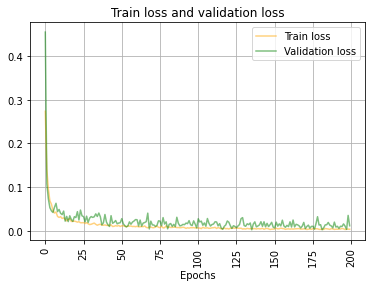

In [16]:
x_axis = np.arange(num_epochs)

#Create the plot for losses
plt.plot(x_axis, train_losses, '-g', alpha = 0.5, label='Train loss', color='orange')
plt.plot(x_axis, val_losses, '-g', alpha = 0.5, label='Validation loss')
plt.title('Train loss and validation loss')
plt.xlabel('Epochs')
plt.xticks(rotation = 90)
plt.legend()
plt.grid()
plt.show()

### Test model

In [17]:
from scipy.spatial.distance import cdist


def test_model(query, candidates):
    """
    The test code bellow will call this function with the following parameters 
    query - the query image (28, 28)
    candidates - numpy array of candidate images, shape (5, 28, 28)
    return - sorted array of the indexes of the images based on the similarty to the query image 
    """
    query = query.reshape(1, 1, 28, 28)
    if torch.cuda.is_available():
        query = torch.Tensor(query).to(device, dtype=torch.float)
        candidates =  torch.Tensor(candidates).to(device, dtype=torch.float)
    query_embedding = mined_model.get_embedding(query).data.cpu().numpy()
    candidates_embedding = []
    for candidate in candidates:
        candidate = candidate.reshape(1, 1, 28, 28)
        candidates_embedding.append(mined_model.get_embedding(candidate).data.cpu().numpy()[0])
    distances = cdist(np.array(query_embedding), np.array(candidates_embedding))[0]
    sorted_idx = list((np.argsort(distances)))
    sorted_indexes = [idx+1 for idx in sorted_idx]
    return np.array(sorted_indexes)

In [18]:
## test top-1
def test_top_1(query, candidates, query_true):
    sorted_indexes = test_model(query, candidates)
    return query_true == sorted_indexes[0]

## test top-3
def test_top_3(query, candidates, query_true):
    sorted_indexes = test_model(query, candidates)
    return np.isin(query_true, sorted_indexes[:3])

top_1_res = np.array([test_top_1(a, b, c) for (a, b, c) in zip(queries, candidates_sets, queries_true)])
top_3_res = np.array([test_top_3(a, b, c) for (a, b, c) in zip(queries, candidates_sets, queries_true)])

top_1 = np.count_nonzero(top_1_res) / queries.shape[0]
print(f"top-1 accuracy: {top_1}")

top_3 = np.count_nonzero(top_3_res) / queries.shape[0]
print(f"top-3 accuracy: {top_3}")


top-1 accuracy: 0.95
top-3 accuracy: 1.0


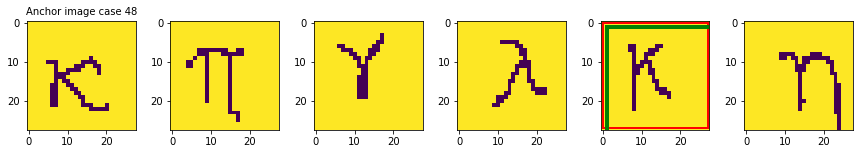

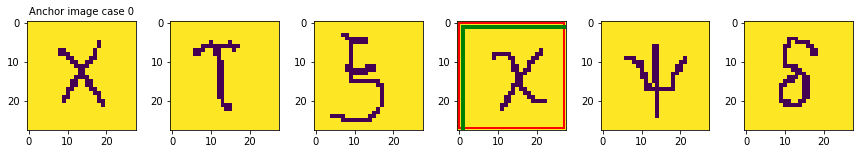

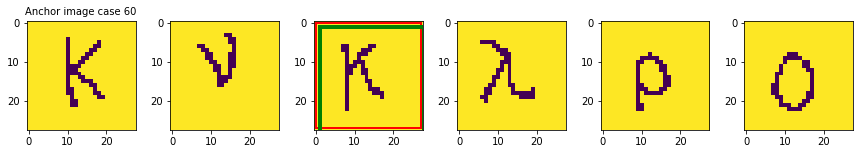

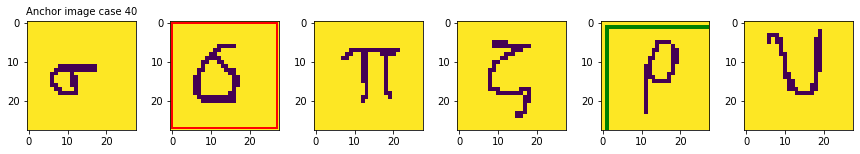

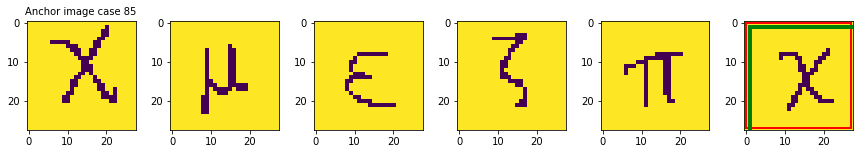

In [70]:
from matplotlib.patches import Rectangle
import random
def plot_results(caseID):
    """
    Plots a single sample of the query dataset
    
    Inputs
    caseID: Integer between 0 and 99, each corresponding to a single sample in the query dataset 
    """
    
    f, axes = plt.subplots(1, 6, figsize=(15,2))
    
    # plot anchor image
    axes[0].imshow(queries[caseID, 0])
    axes[0].set_title(f"Anchor image case {caseID}", fontsize=10)
    
    # show all test images images 
    [ax.imshow(candidates_sets[caseID, i]) for i, ax in enumerate(axes[1:])]
    
    
    # Add the patch to the Axes
    axes[queries_true[caseID]].add_patch(Rectangle((0,0),27,27,linewidth=2, edgecolor='r',facecolor='none'))
    predicted_indices = test_model(queries[caseID, 0], candidates_sets[caseID])
    axes[predicted_indices[0]].add_patch(Rectangle((1,1),27,27,linewidth=4, edgecolor='g',facecolor='none'))

    
    
# plot five random samples of the query datset
indices = random.sample(range(100), 5)
[plot_results(caseID) for caseID in indices] ;